# DIFFUSION MODEL
> Created Nov. 2024 <br>
> Nikhil Bisht<br>

# Definitions

In [1]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from ddpm_conditional import *

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
IMAGEDATA = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/ML_images_data.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.dict'

IMAGESIZE = 128

TARGET = ['Vx_f', 'Vy_f', 'Vz_f','Density_f']
POS_FEAT = ['X_f', 'Y_f', 'Z_f','X_i', 'Y_i', 'Z_i']
FEATURES = ['Vx_i', 'Vy_i', 'Vz_i','Density_i']

FRAMES = [30, 90]

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


# Functions

In [2]:
def get_data(args, input_arr, labels):
    dataset = TensorDataset(input_arr, labels)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

def plot_3dhist(img, edges, filename='xy_hist.png', dont_show = False):
    #img is a IMAGESIZExIMAGESIZExIMAGESIZE array
    xy_data = np.sum(img,axis=2)
    zy_data = np.sum(img,axis=0)
    xz_data = np.sum(img,axis=1)
    x_edges = edges[0]
    y_edges = edges[1]
    z_edges = edges[2]

    fig = plt.figure(figsize=(13, 4))
    fig.tight_layout()
    
    ax  = fig.add_subplot(1, 3, 1)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    c = ax.pcolormesh(x_edges, y_edges, xy_data.T)
    fig.colorbar(c, ax=ax)

    ax2  = fig.add_subplot(1, 3, 2)
    ax2.set_xlabel(r'$z$')
    ax2.set_ylabel(r'$y$')
    c = ax2.pcolormesh(z_edges, y_edges, zy_data.T)
    fig.colorbar(c, ax=ax2)

    ax3  = fig.add_subplot(1, 3, 3)
    ax3.set_xlabel(r'$x$')
    ax3.set_ylabel(r'$z$')
    c = ax3.pcolormesh(x_edges, z_edges, xz_data.T)
    fig.colorbar(c, ax=ax3)
    
    if filename:
        plt.savefig(filename)
    
    if dont_show==False:
        plt.show()
    plt.close()


# Load Images

noise_conditional.jpg


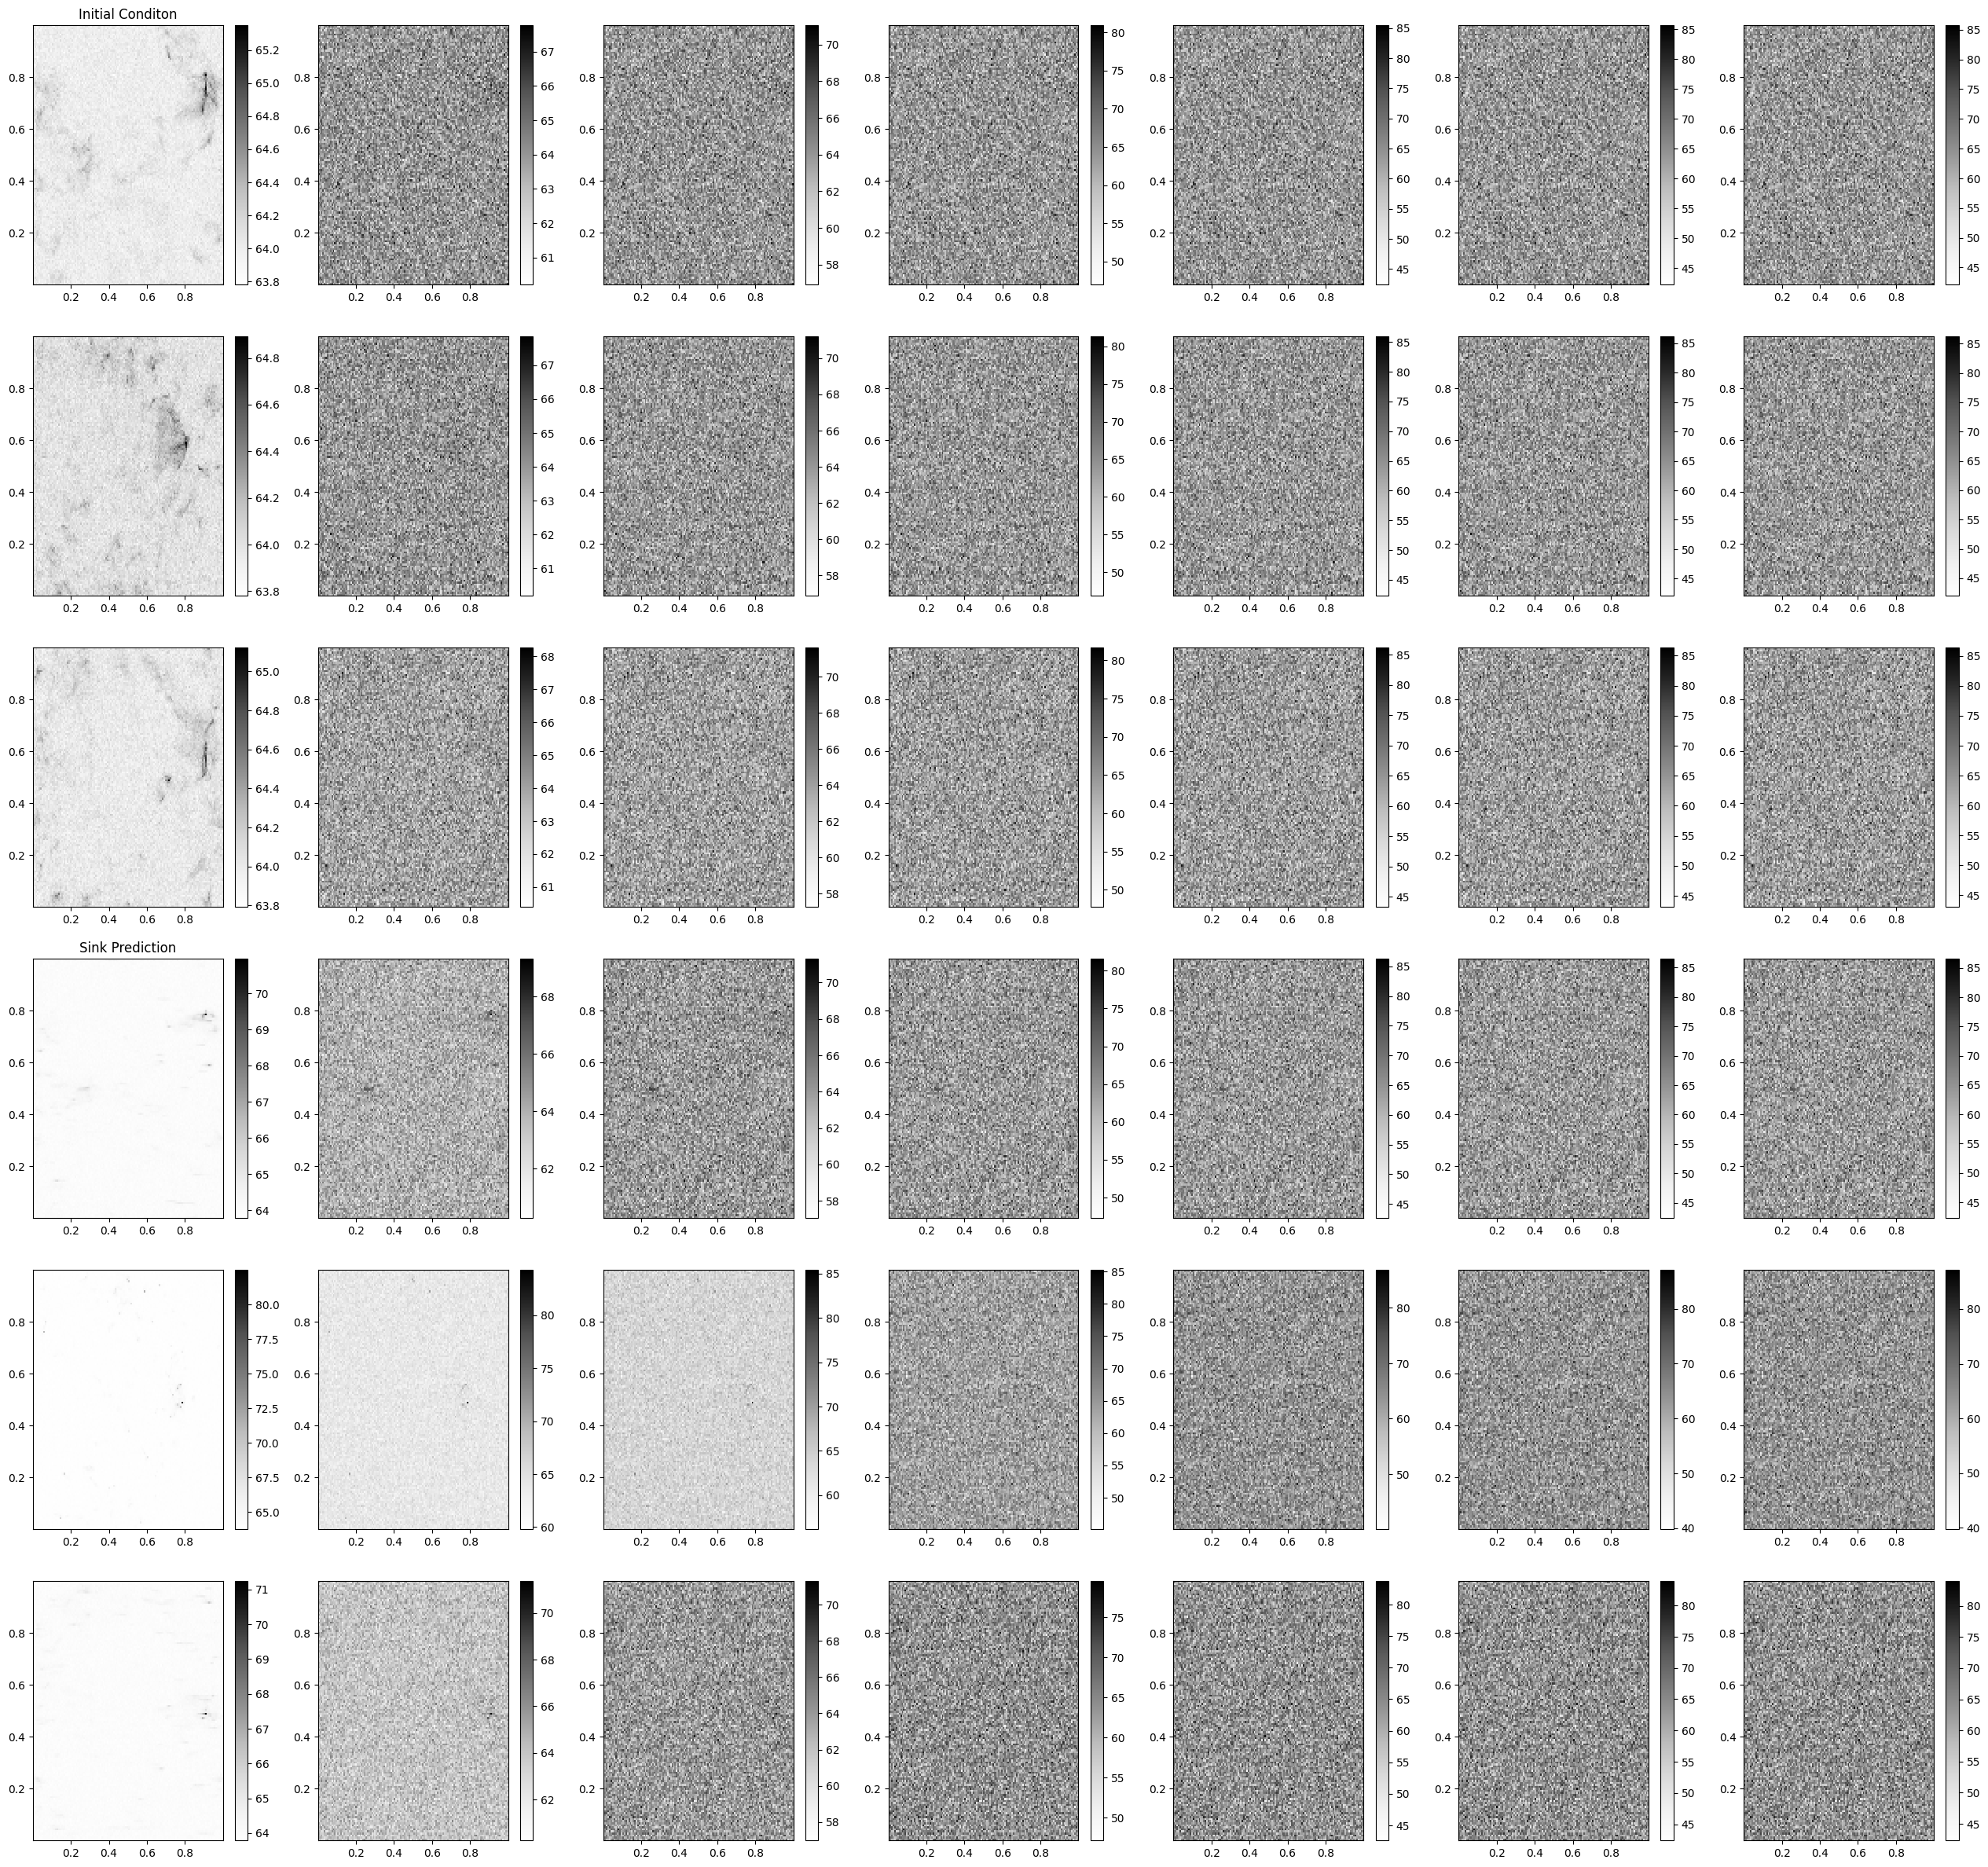

In [3]:
image_arr = []
h5f = h5py.File(IMAGEDATA,'r')
labels = []
edges_IC = []
scalor_IC = []
for num in range(int(len(h5f.keys())/3)):
    H = h5f['img_'+str(num)][:]
    H = H.astype(np.float32)
    image_arr.append(H)
    edges_arr = h5f['imgedges_'+str(num)][:]
    edges_IC.append(edges_arr)
    scalor_init = h5f['imgscalor_'+str(num)]
    scalor_IC.append(scalor_init)
    labels.append(torch.tensor(num))
h5f.close()
#noising test

parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.batch_size = 1
args.image_size = IMAGESIZE
args.dataset_path = IMAGEDATA
args.device = DEVICE

dataloader = get_data(args, torch.tensor(np.array(image_arr)), torch.tensor(np.array(labels)))

diff = Diffusion(device="cpu")

image = next(iter(dataloader))[0][0]
t = torch.Tensor([0, 50, 100, 300, 600, 700, 999]).long()

noised_image, _ = diff.noise_images(image, t)
save_images(noised_image.add(1).mul(0.5), edges_IC[0], "noise_conditional.jpg")

In [22]:
import torch.nn as nn
import torch.nn.functional as F

def pos_encoding(t, channels):
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device=args.device).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        print("before",t.shape)
        print("self.emb_layer(t)",self.emb_layer(t).shape)
        emb = self.emb_layer(t)[:, :, None, None, None].repeat(1, 1, x.shape[-3], x.shape[-2], x.shape[-1])
        print("emb",emb.shape)
        return x + emb

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        print("x",x.shape)
        print( self.channels)
        print( self.size)
        print("x.view", x.view(-1, self.channels, self.size * self.size * self.size).swapaxes(1, 2).shape)
        x = x.view(-1, self.channels, self.size * self.size * self.size).swapaxes(1, 2)
        print("view done")
        x_ln = self.ln(x)
        print("ln done")
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        print("mha done")
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        print("attention_value done")
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size, self.size)

#launch training
args.run_name = "DDPM_conditional"
args.epochs = 11
args.batch_size = 1
args.channel = 2
args.image_size = IMAGESIZE
args.dataset_path = IMAGEDATA
args.device = DEVICE
args.lr = 3e-4
args.noise_steps = 1000
setup_logging(args.run_name)
device = args.device
channel = args.channel
noise_steps = args.noise_steps
model = UNet_conditional(c_in=channel, c_out=channel, time_dim=256, device=device).to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
mse = nn.MSELoss()
diffusion = Diffusion(noise_steps = noise_steps, n_channels = channel, img_size=args.image_size, device=device)
logger = SummaryWriter(os.path.join("runs", args.run_name))
l = len(dataloader)
ema = EMA(0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

c_in = 2
time_dim = 256
inc = DoubleConv(c_in, 32)
down1 = Down(32, 64)
sa1 = SelfAttention(64, 16)
down2 = Down(64, 128)
sa2 = SelfAttention(128, 8)
down3 = Down(128, 128)
sa3 = SelfAttention(128, 4)

images = next(iter(dataloader))[0]
print("images",images.shape)
t = diffusion.sample_timesteps(images.shape[0]).to(device)
print("t",t.shape,t)
x, noise = diffusion.noise_images(images, t)
print("x",x.shape)
print("noise",noise.shape)
t = t.unsqueeze(-1).type(torch.float)
print("t",t.shape,t)
t = pos_encoding(t, time_dim)
print("t",t.shape,t)

print("yay", x.shape)
x1 = inc(x)
print("yay2", x1.shape)
x2 = down1(x1, t)
print("yay3", x2.shape)
x2 = sa1(x2)
print("yay4", x2.shape)
x3 = down2(x2, t)
x3 = sa2(x3)
x4 = down3(x3, t)
x4 = sa3(x4)
print("yay5", x4.shape)
#x = x.view(-1, self.channels, self.size * self.size * self.size).swapaxes(1, 2)

images torch.Size([1, 2, 128, 128, 128])
t torch.Size([1]) tensor([639])
x torch.Size([1, 2, 128, 128, 128])
noise torch.Size([1, 2, 128, 128, 128])
t torch.Size([1, 1]) tensor([[639.]])
t torch.Size([1, 256]) tensor([[-0.9511, -0.7673,  0.4177, -0.2841,  0.9960, -0.1912,  0.2616,  0.2672,
          0.9301,  0.9817, -0.1540,  0.5156, -0.6540, -0.5411,  0.7633, -0.3668,
          0.8456, -0.4397, -0.8100, -0.5026,  0.6701,  0.3536, -0.6644,  0.4006,
          0.5096, -0.8778, -0.8479, -0.4469, -0.3793, -0.6861, -0.9993, -0.4328,
          0.8763,  0.2248, -0.9369,  0.9418, -0.7134,  0.5721, -0.6090,  0.7928,
         -0.9811,  0.8995, -0.2943, -0.6307,  0.9707, -0.0571, -0.9743,  0.2731,
          0.9773, -0.0455, -0.9760, -0.5444,  0.5268,  0.9993,  0.5275, -0.3479,
         -0.9332, -0.9126, -0.4035,  0.2646,  0.7855,  0.9971,  0.8893,  0.5510,
          0.1066, -0.3305, -0.6814, -0.9060, -0.9968, -0.9681, -0.8457, -0.6593,
         -0.4366, -0.2009,  0.0299,  0.2434,  0.4322,  0.5924

In [23]:
#launch training
args.run_name = "DDPM_conditional"
args.epochs = 11
args.batch_size = 1
args.channel = 2
args.image_size = IMAGESIZE
args.dataset_path = IMAGEDATA
args.device = DEVICE
args.lr = 3e-4
args.noise_steps = 1000
setup_logging(args.run_name)
device = args.device
channel = args.channel
noise_steps = args.noise_steps
model = UNet_conditional(c_in=channel, c_out=channel, time_dim=256, device=device).to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
mse = nn.MSELoss()
diffusion = Diffusion(noise_steps = noise_steps, n_channels = channel, img_size=args.image_size, device=device)
logger = SummaryWriter(os.path.join("runs", args.run_name))
l = len(dataloader)
ema = EMA(0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

for epoch in range(args.epochs):
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(dataloader)
    for i, (images, _) in enumerate(pbar):
        images = images.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        print(x_t.shape, t.shape)
        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.step_ema(ema_model, model)

        pbar.set_postfix(MSE=loss.item())
        logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

    if epoch % 10 == 0:
        sampled_images = diffusion.sample(model, initial_condition_image = images[0][0],n=images.shape[0], cfg_scale=0)
        ema_sampled_images = diffusion.sample(ema_model, initial_condition_image = images[0][0],n=images.shape[0], cfg_scale=0)
        save_images(sampled_images, edges, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        save_images(ema_sampled_images, edges, os.path.join("results", args.run_name, f"{epoch}_ema.jpg"))
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))
        torch.save(ema_model.state_dict(), os.path.join("models", args.run_name, f"ema_ckpt.pt"))
        torch.save(optimizer.state_dict(), os.path.join("models", args.run_name, f"optim.pt"))
#cddpm_model, cddpm_emamodel, cddpm_optimizer, cddpm_diffusion = train(args,dataloader, edges = edges_IC[0])

05:17:09 - INFO: Starting epoch 0:
  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([1, 2, 128, 128, 128]) torch.Size([1])
shape! torch.Size([1, 128, 64, 64, 64])


: 

In [10]:
#load model
model = UNet_conditional(c_in=args.channel, c_out=args.channel, time_dim=256, device=args.device).to(args.device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
diffusion = Diffusion(noise_steps = args.noise_steps, n_channels = args.channel, img_size=args.image_size, device=args.device)

# Load the checkpoint
checkpoint_model = torch.load(os.path.join("models", args.run_name, f"ckpt.pt"), weights_only=True)
checkpoint_optim = torch.load(os.path.join("models", args.run_name, f"optim.pt"), weights_only=True)
model.load_state_dict(checkpoint_model)
optimizer.load_state_dict(checkpoint_optim)
sampled_image = diffusion.get_prediction(model, 1, initial_dataset_rotated[-1][:,0:2], IMAGESIZE = args.image_size)

07:02:27 - INFO: Sampling 1 new images....
0it [00:00, ?it/s]


RuntimeError: expected scalar type Double but found Float

## Stats
- x1 == Gaussian distribution; N = 8000; B = 16000
    - T = 10
        - $FID: 2.4463259683877026e-03; KS: [0.1693125 0.2083125]; P-value: [4.05985932e-134 1.79622800e-203]$

